In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

In [3]:
# Load Dataset

image_path = './dataset/'

images = []

for filename in os.listdir(image_path):
    img = tf.keras.preprocessing.image.load_img(f"{image_path}{filename}", target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

In [4]:
# Preprocess Images

images = np.asarray(images).astype(np.float32)/255.0

x_train = images[:-10]
x_test = images[-10:]

In [5]:
BATCH_SIZE = 100
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
# Layer mean dan layer st.dev
LATENT_DIM = 32
MAX_EPOCHS = 300
LEARNING_RATE = 0.0001

print(IMAGE_ORIGINAL_SHAPE, IMAGE_SIZE)

(128, 128, 3) 49152


In [6]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim = dim[0]
        z_dim = dim[1]

        # Correct attribute assignments with self.
        self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        self.fc4 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

        self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
        self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

    def encode(self, x):
        x = self.encoder_batch_norm(x)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(tf.shape(std))
        return mu + eps * std
        
    def decode_logits(self, z):
        h = self.fc4(z)
        h = self.fc5(h)
        return self.decoder_batch_norm(h)
    
    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))
    
    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
        return x_recon_logits, mu, log_var


In [7]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE))
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

c:\Users\theo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

loss_history = []
kl_div_history = []

num_batches = x_train.shape[0] // BATCH_SIZE

for epoch in range(MAX_EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis = -1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)
        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(f"Epoch[{epoch+1}/{MAX_EPOCHS}] Reconstruction Loss: {float(reconstruction_loss):.2f}, KL DIV: {float(kl_div):.2f}, Loss : {float(loss):.2f}")
    kl_div_history.append(kl_div)
    loss_history.append(loss)

Epoch[1/300] Reconstruction Loss: 30680.96, KL DIV: 43.29, Loss : 30724.25
Epoch[2/300] Reconstruction Loss: 30380.77, KL DIV: 372.72, Loss : 30753.49
Epoch[3/300] Reconstruction Loss: 30070.40, KL DIV: 202.60, Loss : 30273.00
Epoch[4/300] Reconstruction Loss: 29110.84, KL DIV: 738.75, Loss : 29849.59
Epoch[5/300] Reconstruction Loss: 28582.63, KL DIV: 557.07, Loss : 29139.70
Epoch[6/300] Reconstruction Loss: 27506.01, KL DIV: 808.69, Loss : 28314.69
Epoch[7/300] Reconstruction Loss: 26100.22, KL DIV: 1318.38, Loss : 27418.60
Epoch[8/300] Reconstruction Loss: 24826.76, KL DIV: 1563.68, Loss : 26390.45
Epoch[9/300] Reconstruction Loss: 23542.91, KL DIV: 1776.14, Loss : 25319.05
Epoch[10/300] Reconstruction Loss: 22074.69, KL DIV: 2151.57, Loss : 24226.26
Epoch[11/300] Reconstruction Loss: 20723.40, KL DIV: 2593.97, Loss : 23317.37
Epoch[12/300] Reconstruction Loss: 19487.21, KL DIV: 3003.61, Loss : 22490.82
Epoch[13/300] Reconstruction Loss: 18488.00, KL DIV: 3288.70, Loss : 21776.71
Ep

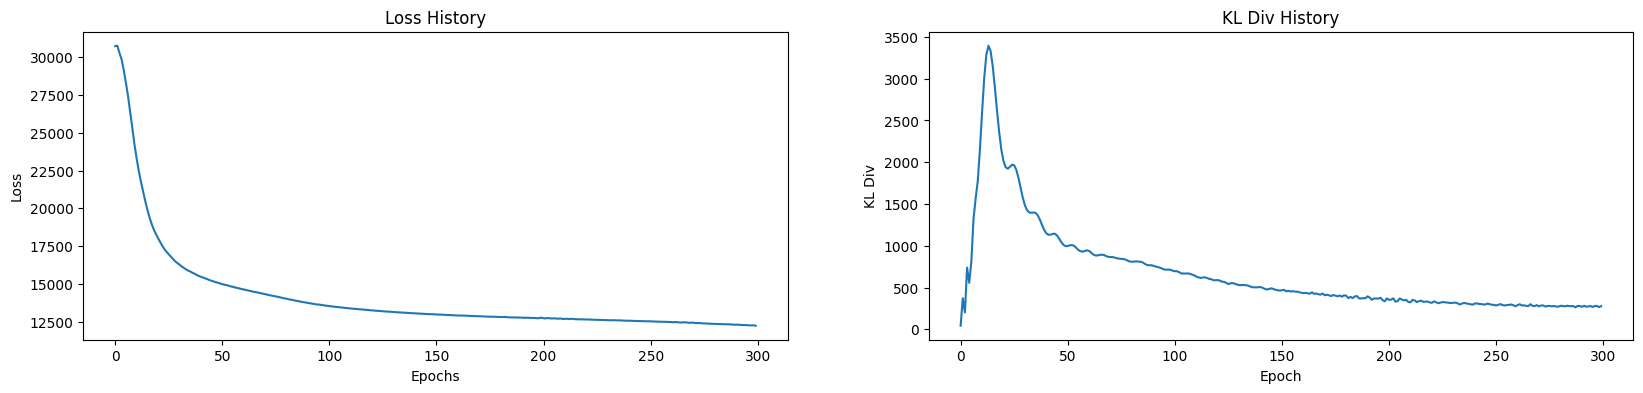

In [9]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History")

plt.subplot(1,2,2)
plt.plot(kl_div_history)
plt.xlabel("Epoch")
plt.ylabel("KL Div")
plt.title("KL Div History")

plt.show()

In [10]:
# Menggunakan model untuk rekonstruksi data test

mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)

# mencoba mencampur fitur yang ada di dataset kita,
# kalo sol merah sendiri berarti nanti bakal dicampur sama yang biru, cthnya
z = tf.random.normal([BATCH_SIZE, LATENT_DIM])

out = model.decode(z)
out = tf.reshape(out, [-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]]).numpy() * 255
out = out.astype(np.uint8)

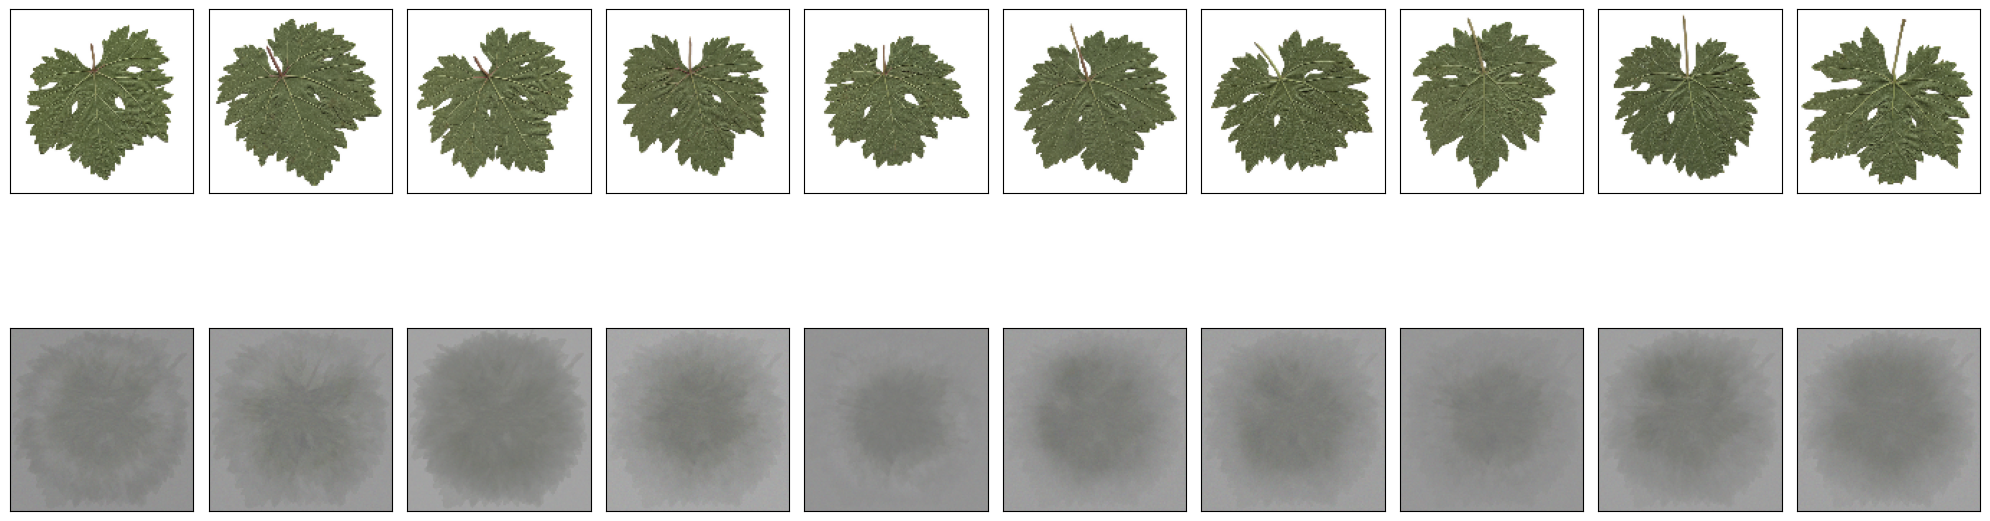

In [11]:
number = 10
plt.figure(figsize=(20, 8))

for index in range(number):
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_test[index].reshape(IMAGE_ORIGINAL_SHAPE), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for index in range(number):
    ax = plt.subplot(2, number, number + index + 1)
    plt.imshow(out[index].reshape(IMAGE_ORIGINAL_SHAPE), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.tight_layout()
plt.show()

In [12]:
model.save('model.h5')